In [28]:
# temp = df["title"].str.contains("Multi-sig Governance")
# temp = df["title"].str.contains("Gauge Weight for Week of")
# temp = df["title"].str.contains("LAV for week of")

In [1]:
import pandas as pd
import numpy as np

df = pd.read_excel("proposals_preprocess_0812_nlp.xlsx")
df = df.replace('', None)
df_raw = df.copy()
print(df.shape)
print(df[df["body_lower"].isna()].shape)
print(df[df["body_nlp"].isna()].shape)

(20750, 41)
(253, 41)
(345, 41)


In [2]:
df["space_id"].value_counts()

space_id
snapshot.dcl.eth    2301
cakevote.eth        1491
aave.eth             653
index-coop.eth       641
balancer.eth         528
                    ... 
signinhere.eth         1
cuchorapido.eth        1
pozoaxel.eth           1
defjnite.eth           1
haitang.eth            1
Name: count, Length: 245, dtype: int64

In [3]:
from collections import Counter

content = ' '.join(df["body_nlp"].dropna())
content = content.split()

word_counts = Counter(content)
word_counts = dict(word_counts)
word_counts = pd.DataFrame(word_counts.items(), columns=["word", "count"])
word_counts = word_counts.sort_values(by="count", ascending=False)
word_counts = word_counts.reset_index(drop=True)

word_counts.head(20).T

0      1          2      3        4      5       6      7   \
word   proposal   vote  liquidity   user  project  would  market   team   
count     39911  33658      18535  18476    16890  16421   16014  15223   

          8           9       10     11      12       13       14     15  \
word    make  governance  create   have  reward  provide  support  month   
count  13792       13494   12795  12432   12211    12154    12030  11951   

            16     17     18        19  
word   propose   also  asset  treasury  
count    11811  11571  11283     11250

In [2]:
df = df_raw[ ~(df_raw["body_nlp"].isna() | df_raw["body_lower"].isna())]
# team support
df["body_nlp"] = df["body_nlp"].str.replace(r"project|proposal|community|propose|vote|user|make|create|need|month|use|allow|see|network", "", regex=True)

C:\Users\DYK\AppData\Local\Temp\ipykernel_2020\3173949007.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["body_nlp"] = df["body_nlp"].str.replace(r"project|proposal|community|propose|vote|user|make|create|need|month|use|allow|see|network", "", regex=True)


# Clustering

In [3]:
# Drop the proposals with less than 60 length

avail_len = 60
temp = df[~df["body_nlp"].isna()].copy()
temp["nlp_len"] = temp["body_nlp"].apply(len)

print(temp[temp["nlp_len"] < avail_len][["body_nlp", "space_id"]].value_counts())
df_ = df[~df["id"].isin(temp[temp["nlp_len"] < avail_len]["id"])]
print(df_.shape)
df = df_
df = df.reset_index(drop=True)

body_nlp                                                 space_id              
holder choose change week control want reward            unidexapp.eth             26
metagovernance   latest                                  index-coop.eth            25
metagovernance   latest  have                            index-coop.eth            23
  newest                                                 index-coop.eth            12
background reason                                        arbitrumfoundation.eth    12
                                                                                   ..
detail please read                                       ens.eth                    1
directly connect buy  option interaction world activity  cakevote.eth               1
distribute restore holder affect exploit forum           badgerdao.eth              1
distribute utc price                                     cakevote.eth               1
york together shape truly represent aspiration desire    orb

In [4]:
from util.similar.cosine import cosine, filter_similar

cos_mat, X = cosine(df["body_nlp"])
distance_matrix = 1 - cos_mat
np.fill_diagonal(distance_matrix, 0)
cos_mat.shape

(19426, 19426)

In [11]:
from sklearn.metrics import silhouette_score

# 실루엣 점수 해석:
# 1에 가까울 때: 클러스터가 잘 분리되어 있고, 각 클러스터 내부 데이터 포인트들이 서로 가깝다는 의미.
# 0에 가까울 때: 클러스터 간의 경계가 명확하지 않고, 데이터가 서로 중첩된 경우.
# -1에 가까울 때: 클러스터링이 잘못되어 데이터가 잘못된 클러스터에 할당된 경우.

def silhouette(X, labels):
    return silhouette_score(X, labels, metric='precomputed')

### KMeans

In [5]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [13]:
silhouette_scores = []
inertia = []
K_range = range(2, 16)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42,  n_init='auto')
    labels = kmeans.fit_predict(distance_matrix)
    silhouette_scores.append(silhouette(distance_matrix, labels))
    inertia.append(kmeans.inertia_)

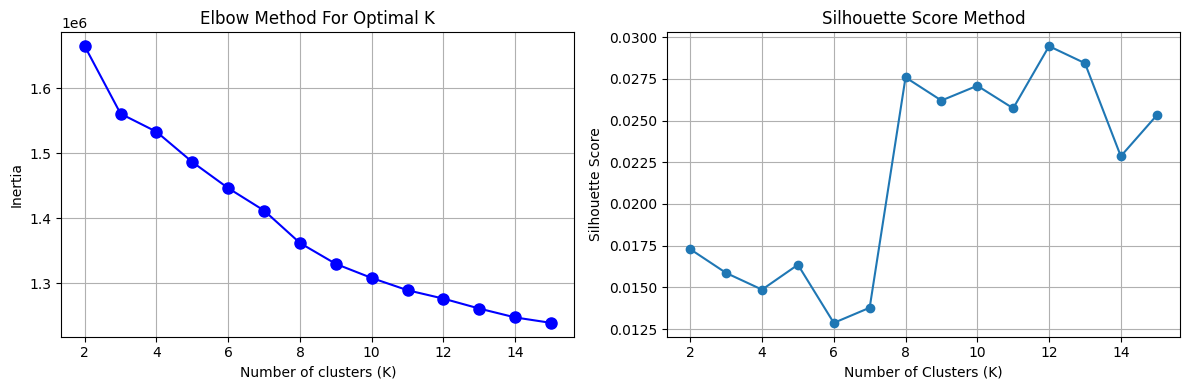

In [14]:
fig, ax1 = plt.subplots(1, 2, figsize=(12, 4))

ax1[0].plot(K_range, inertia, 'bo-', markersize=8)
ax1[0].set_xlabel('Number of clusters (K)')
ax1[0].set_ylabel('Inertia')
ax1[0].set_title('Elbow Method For Optimal K')
ax1[0].grid(True)

ax1[1].plot(K_range, silhouette_scores, marker='o')  # 실루엣 점수는 K=2부터 시작하므로
ax1[1].set_xlabel('Number of Clusters (K)')
ax1[1].set_ylabel('Silhouette Score')
ax1[1].set_title('Silhouette Score Method')
ax1[1].grid(True)

plt.tight_layout()
plt.show()

In [6]:
K = 8
# silhouette_scores.index(max(silhouette_scores)) + 2

kmeans = KMeans(n_clusters=K, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(distance_matrix)
centers = kmeans.cluster_centers_

pca = PCA(n_components=3)
X_pca = pca.fit_transform(distance_matrix)
print(X_pca.shape)

fig = go.Figure()
fig.add_trace(go.Scatter3d(
    x=X_pca[:, 0], y=X_pca[:, 1], z=X_pca[:, 2],
    mode='markers',
    marker=dict(size=5, color=clusters, colorscale='Viridis', opacity=0.5)
))
fig.add_trace(go.Scatter3d(
    x=centers[:, 0], y=centers[:, 1], z=centers[:, 2],
    mode='markers',
    marker=dict(size=10, color='red', symbol='x'),
    name='Cluster Centers'
))
fig.update_layout(
    title="3D PCA of High-Dimensional Data",
    scene=dict(
        xaxis_title='Principal Component 1',
        yaxis_title='Principal Component 2',
        zaxis_title='Principal Component 3'
    ),
    showlegend=False,
    width=1000,
    height=700
)
fig.show()

(19426, 3)


In [7]:
df["cluster"] = clusters
df["cluster"].value_counts().sort_index()

cluster
0     862
1     495
2    1500
3    7271
4    5045
5    1741
6    2001
7     511
Name: count, dtype: int64

In [8]:
temp = pd.DataFrame({
    f"{w}{i}": df[df["cluster"] == i]["space_id"].value_counts().head(10).index  if w=="word" \
        else df[df["cluster"] == i]["space_id"].value_counts().head(10).values \
            for i in range(K) for w in ["word", "count"]
})

temp.head(10)

word0  count0             word1  count1  \
0        snapshot.dcl.eth     219  snapshot.dcl.eth     473   
1  arbitrumfoundation.eth     167      cakevote.eth       5   
2          gitcoindao.eth      45           poh.eth       3   
3       banklessvault.eth      40       bgansv2.eth       2   
4            balancer.eth      21    theheaddao.eth       1   
5       lido-snapshot.eth      17          metfi.io       1   
6         foundersdao.eth      12       doodles.eth       1   
7  mainnet.ssvnetwork.eth      12         jbdao.eth       1   
8            sharkdao.eth      11       benddao.eth       1   
9                 ens.eth      11      balancer.eth       1   

                word2  count2              word3  count3              word4  \
0        cakevote.eth     304       cakevote.eth     892   snapshot.dcl.eth   
1        kalmyapp.eth     150   snapshot.dcl.eth     714          jbdao.eth   
2   bancornetwork.eth      55     aavegotchi.eth     186  shapeshiftdao.eth   
3           qidao.eth      43         futera.eth     183    metislayer2.eth   
4      spookyswap.eth      40       glmrapes.eth     123     aavegotchi.eth   
5      aavegotchi.eth      39  bancornetwork.eth     119    krausehouse.eth   
6  decentralgames.eth      36          jbdao.eth     115        apecoin.eth   
7   lido-snapshot.eth      31        apecoin.eth     111         mocana.eth   
8        glmrapes.eth      23  lido-snapshot.eth     106       sharkdao.eth   
9        balancer.eth      22        bgansv2.eth      97       balancer.eth   

   count4              word5  count5              word6  count6  \
0     775           aave.eth     389  bancornetwork.eth     260   
1     196           hvax.eth     175       balancer.eth     248   
2     167          qidao.eth     102           aave.eth     128   
3     144           frax.eth      83           frax.eth      87   
4     139        gearbox.eth      62       cakevote.eth      54   
5     136          jbdao.eth      61     olympusdao.eth      50   
6     130     olympusdao.eth      44    metislayer2.eth      47   
7     108      dforcenet.eth      41         stgdao.eth      41   
8     100  bancornetwork.eth      40     aavegotchi.eth      41   
9      94        pushdao.eth      38    aurafinance.eth      39   

                        word7  count7  
0                     cvx.eth     136  
1                    frax.eth      94  
2                balancer.eth      58  
3            equilibriafi.eth      40  
4              timelessfi.eth      28  
5                floordao.eth      24  
6  gauges.equilibria-xeqb.eth      21  
7                stakedao.eth      17  
8             aurafinance.eth      13  
9                   veyfi.eth      11

In [ ]:
# TODO: 비중 높은 protocol의 백서를 가지고 와서 unique word cleansing

!pip install --user -q wordcloud

In [ ]:
# 

In [9]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

def word_cloud(df, cluster):
    text = " ".join(df[df["cluster"] == cluster]["body_nlp"])
    return WordCloud(width=800, height=400, max_words=200, background_color='white').generate(text)

words = []
for i in range(K):
    wc = word_cloud(df, i)
    words.append(wc.words_)

temp = pd.DataFrame({
    f"{w}{i}": list(words[i].keys() if w=="word" else words[i].values())  for i in range(K) for w in ["word", "count"] 
})

temp.head(20)

word0    count0              word1    count1         word2  \
0             grant  1.000000       scene locate  1.000000         stake   
1         committee  0.461393      interest list  0.936652        reward   
2     grant program  0.253908   list description  0.936652      increase   
3              team  0.234960       add interest  0.714932     incentive   
4           include  0.228328         locate add  0.712670             d   
5           provide  0.224064              event  0.248869        holder   
6           support  0.213643      locate remove  0.221719      emission   
7        governance  0.211748    remove interest  0.221719      treasury   
8            budget  0.211748            gallery  0.214932       support   
9         ecosystem  0.200379       parcel scene  0.178733    governance   
10               pa  0.176220          metaverse  0.142534          team   
11  grant committee  0.175272           add deny  0.142534          week   
12          grantee  0.174325          deny name  0.142534        market   
13           proces  0.171009          name list  0.142534  stake reward   
14           follow  0.169588           list ban  0.142534        staker   
15                d  0.166746    ban description  0.142534       program   
16         treasury  0.163903  description scene  0.126697        option   
17             fund  0.159166             artist  0.122172       provide   
18          approve  0.153008              build  0.097285      allocate   
19          program  0.152534           wearable  0.088235     liquidity   

      count2       word3    count3        word4    count4           word5  \
0   1.000000           d  1.000000         team  1.000000          market   
1   0.669919        team  0.948617      include  0.741833           asset   
2   0.328997      follow  0.897233      support  0.701717       liquidity   
3   0.313279      option  0.867194            d  0.584562        contract   
4   0.261247        give  0.811067        event  0.571038        increase   
5   0.244986    treasury  0.792885      provide  0.567695           vault   
6   0.242276    increase  0.750198       market  0.499620               d   
7   0.238482     current  0.747826         help  0.461176        strategy   
8   0.232520     include  0.743874     platform  0.455706        treasury   
9   0.232520     support  0.743874       follow  0.454946         deposit   
10  0.229810       price  0.736759   governance  0.441574         support   
11  0.226558        help  0.690909    ecosystem  0.400395      deployment   
12  0.224390      holder  0.671937  development  0.389758      motivation   
13  0.211382  governance  0.645850   experience  0.389606          follow   
14  0.209756          pa  0.637154       proces  0.384896            risk   
15  0.204878      market  0.616601     treasury  0.381401           price   
16  0.199458        name  0.606324  contributor  0.358608   interest rate   
17  0.196206         day  0.595257       design  0.356329         provide   
18  0.185908  work group  0.581818     contract  0.343869          deploy   
19  0.184282      update  0.573913        build  0.342045  risk parameter   

      count5       word6    count6                word7    count7  
0   1.000000   liquidity  1.000000     gauge controller  1.000000  
1   0.891909      market  0.575544          curve gauge  0.755725  
2   0.594812       asset  0.444767            liquidity  0.698473  
3   0.550340           d  0.420725         gauge weight  0.648855  
4   0.529957    treasury  0.365803             emission  0.606870  
5   0.480544      reward  0.360000                gauge  0.587786  
6   0.446572     support  0.353990           governance  0.564885  
7   0.439160     provide  0.329948         gauge system  0.473282  
8   0.426189   incentive  0.301762             increase  0.450382  
9   0.420012   ecosystem  0.286632               reward  0.419847  
10  0.414453    contract  0.272746         action c

In [10]:
def find_common_values(df, columns):
    common = set(df[columns[0]])
    for c in columns[1:]:
        common = common.intersection(set(df[c]))
    return common

common_words = {v:0 for v in find_common_values(temp, [f"word{i}" for i in range(K)])}
print(len(common_words))

for w in (f"word{i}" for i in range(K)):
    for c in common_words.keys():
        if c in temp[w].values:
            common_words[c] += temp[temp[w] == c][f"count{w[-1]}"].values[0]

common_words = dict(sorted(common_words.items(), key=lambda x: x[1], reverse=True))
common_words

13


{'team': 3.251983076560157,
 'd': 3.2286128948367314,
 'support': 2.8988240699967487,
 'include': 2.5840043677593467,
 'provide': 2.3779356514250445,
 'currently': 1.9103864812155467,
 'option': 1.8177944297029263,
 'help': 1.719445129706281,
 'motivation': 1.679525075376449,
 'update': 1.443304247582562,
 'two': 1.3068329619172088,
 'design': 1.2255302282353167,
 'already': 1.0316664729626275}

In [31]:
!pip install -q --user textblob pyLDAvis

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
altair 4.2.2 requires entrypoints, which is not installed.
streamlit 1.21.0 requires pandas<2,>=0.25, but you have pandas 2.2.3 which is incompatible.

[notice] A new release of pip available: 22.3 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [27]:
# cluster 별 sentiment analysis
from textblob import TextBlob

def sentiment_analysis(df, cluster):
    sentiments = []
    for text in df[df["cluster"] == cluster]["body_nlp"]:
        blob = TextBlob(text)
        sentiments.append(blob.sentiment.polarity)
    return sentiments

for i in range(K):
    sentiments = sentiment_analysis(df, i)
    print(f"Cluster {i}: {np.mean(sentiments)}")

Cluster 0: 0.12690826171569075
Cluster 1: 0.08470829152388162
Cluster 2: 0.09913555723494126
Cluster 3: 0.10415454142190425
Cluster 4: 0.11464171604028602
Cluster 5: 0.08757269001113445
Cluster 6: 0.10205853629041196
Cluster 7: 0.09106199271841


In [13]:
# cluster 별 topic modeling
import gensim
import pyLDAvis
import pyLDAvis.gensim_models
from gensim.models import Phrases

def visualize_topics(df, cluster):
    all_tokens = [x.split() for x in df[df["cluster"] == cluster]["body_nlp"]]
    dictionary = gensim.corpora.Dictionary(all_tokens)
    corpus = [dictionary.doc2bow(text) for text in all_tokens]
    lda = gensim.models.LdaModel(corpus, num_topics=5)
    lda_display = pyLDAvis.gensim_models.prepare(lda, corpus, dictionary)
    pyLDAvis.save_html(lda_display, f"report/lda/lda_cluster_{cluster}.html")


for i in range(K):
    print(f"----- Cluster {i} --------")
    visualize_topics(df, i)
    print()


----- Cluster 0 --------

----- Cluster 1 --------

----- Cluster 2 --------

----- Cluster 3 --------

----- Cluster 4 --------

----- Cluster 5 --------

----- Cluster 6 --------

----- Cluster 7 --------



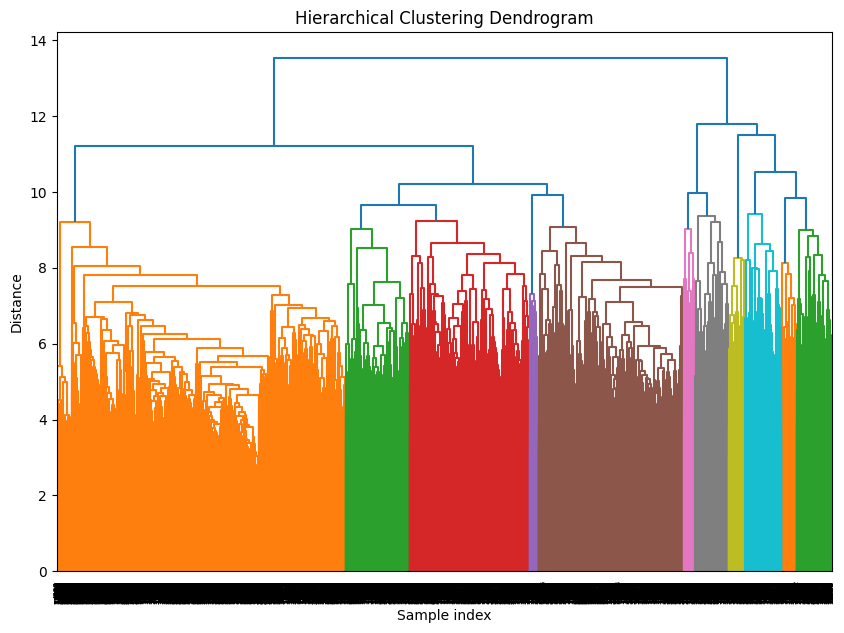

In [17]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(cos_mat, method='complete')

plt.figure(figsize=(15, 7))
dendrogram(Z)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample index")
plt.ylabel("Distance")
plt.xticks(rotation=90)
plt.show()

In [8]:
openFile = True

if openFile:
    tsne_results = pd.read_excel("tsne_results.xlsx").values
    print(tsne_results.shape)
else:
    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=3, random_state=42)
    tsne_results = tsne.fit_transform(X.toarray())
    pd.DataFrame(tsne_results).to_excel("tsne_results.xlsx", engine="openpyxl", index=False)

(14068, 3)


In [28]:
from sklearn.cluster import DBSCAN
# https://www.youtube.com/watch?v=RDZUdRSDOok

eps_values = np.arange(0.50, 0.91, 0.05)
min_samples_values = range(10, 50, 2)
# leaf_sizes = range(10, 30, 2)
leaf_size=30

best = dict(
    score=np.inf,
    eps=0, min_samples=0, leaf_size=30,
    n_clusters=0, n_noise=0, labels=None
)
result = [{}]
 
can_noise = unique_df.shape[0] * 0.5

for eps, min_samples in ((eps, min_samples) for eps in eps_values for min_samples in min_samples_values):
    # for leaf_size in leaf_sizes:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, leaf_size=leaf_size, metric='precomputed', n_jobs=-1) 
        labels = dbscan.fit_predict(distance_matrix)
        unique, count = np.unique(labels, return_counts=True)

        n_clusters_ = unique.shape[0] - (1 if -1 in unique else 0)
        n_noise_ = count[0]

        if n_clusters_ > 2 and n_noise_ < can_noise:
            score = count.mean() - np.median(count)
            if best != result[-1]:
                result.append(best.copy())
            if score < best["score"]:
                best["score"] = score
                best["eps"] = eps
                best["min_samples"] = min_samples
                best["leaf_size"] = leaf_size
                best["n_clusters"] = n_clusters_
                best["n_noise"] = n_noise_
                best["labels"] = labels

print(best)

{'score': 198.0, 'eps': 0.7000000000000002, 'min_samples': 38, 'leaf_size': 30, 'n_clusters': 3, 'n_noise': 6590, 'labels': array([ 0,  0,  0, ..., -1, -1, -1], dtype=int64)}


In [29]:
for b in result:
    for k, v in b.items():
        if k == "labels":
            continue
        print(f"{k}: {v}", end="\t")
    print()


score: inf	eps: 0	min_samples: 0	leaf_size: 30	n_clusters: 0	n_noise: 0	
score: 627.9545454545455	eps: 0.6500000000000001	min_samples: 10	leaf_size: 30	n_clusters: 21	n_noise: 6537	
score: 627.4545454545455	eps: 0.6500000000000001	min_samples: 12	leaf_size: 30	n_clusters: 21	n_noise: 6993	


In [30]:
np.unique(best["labels"], return_counts=True)[1]

array([6590, 7414,   16,   48], dtype=int64)

In [31]:
temp = pd.DataFrame({
    'TSNE_1': tsne_results[:, 0],
    'TSNE_2': tsne_results[:, 1],
    'TSNE_3': tsne_results[:, 2],
    'Cluster': best["labels"],
    'Text': unique_df['body_nlp']
})

In [32]:
import plotly.express as px
import matplotlib.pyplot as plt

fig = px.scatter_3d(temp[temp["Cluster"] > -1], x='TSNE_1', y='TSNE_2', z='TSNE_3', color='Cluster',
                    title='3D Clustering Visualization',
                    labels={'Cluster': 'Cluster Label'},
                    opacity=0.7)

fig.update_layout(
    width=800,   # 그래프의 너비
    height=800   # 그래프의 높이
)

fig.show()

In [35]:
cluster_num = 1
print(unique_df[temp["Cluster"]==cluster_num]['space_id'].value_counts())
unique_df[temp["Cluster"]==cluster_num][['title', 'body_nlp', 'space_id']].head()

stgdao.eth             2
lido-snapshot.eth      1
venus-xvs.eth          1
hop.eth                1
sonnefi.eth            1
beefydao.eth           1
muuu.eth               1
acrossprotocol.eth     1
frax.eth               1
argocoin.eth           1
dforcenet.eth          1
hvax.eth               1
synapseprotocol.eth    1
treasuregaming.eth     1
cakevote.eth           1
Name: space_id, dtype: int64


title  \
1530    Enable bridging wstETH to Arbitrum and Optimism   
1783                          Enable wBTC on KAVA Chain   
3029      Deploy a new in-app swap fully owned by Venus   
3257  [Temperature Check] HIP 6: Deploy a HOP bridge...   
3920  SIP - 11: Add native USDC on Sonne Finance (OP...   

                                               body_nlp           space_id  
1530  follow extension proposal post research forum ...  lido-snapshot.eth  
1783  background deployment great succe partnership ...         stgdao.eth  
3029  primary vote perform temperature proposal nati...      venus-xvs.eth  
3257  temperature line current governance proces int...            hop.eth  
3920  summary proposal advocate add native support p...        sonnefi.eth

# WordCloud

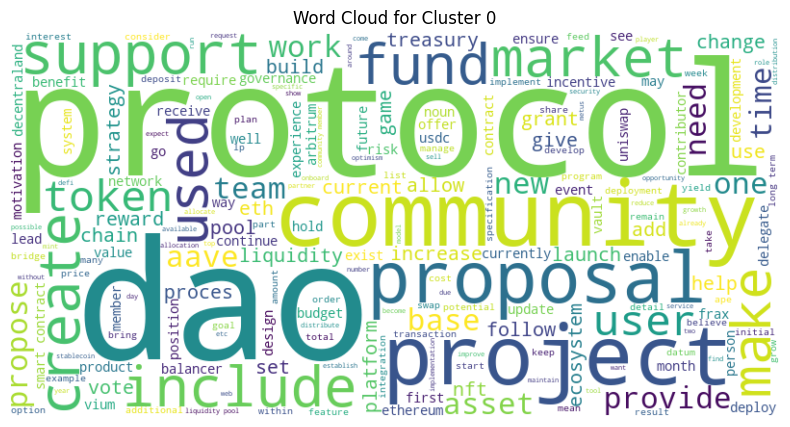

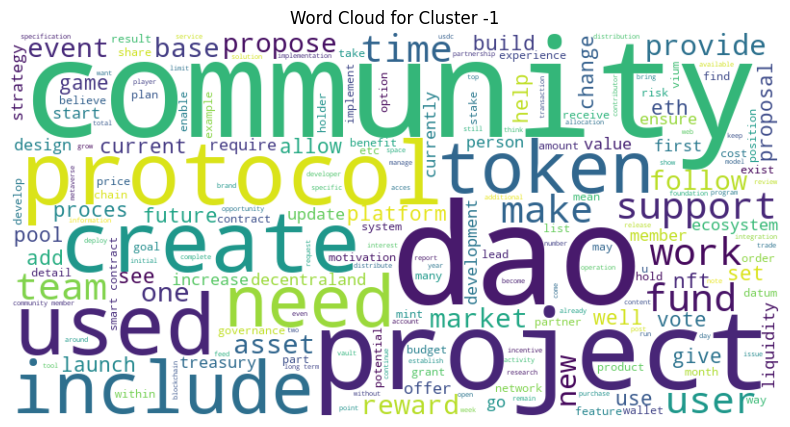

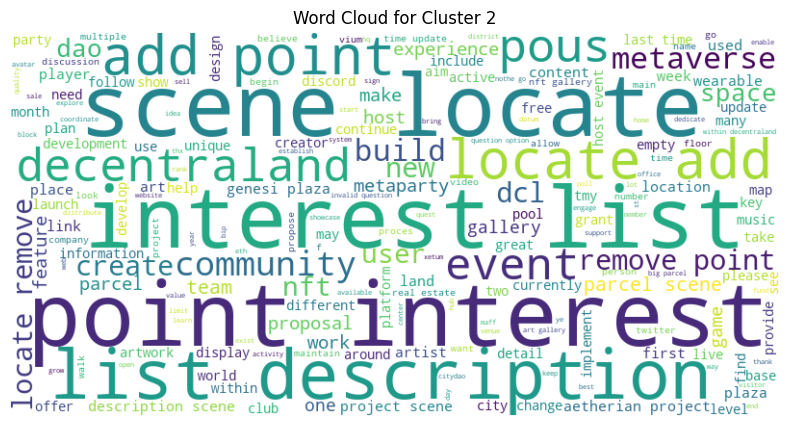

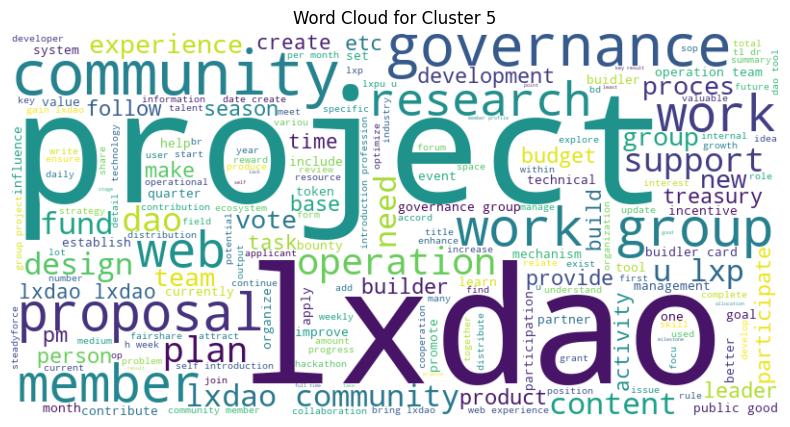

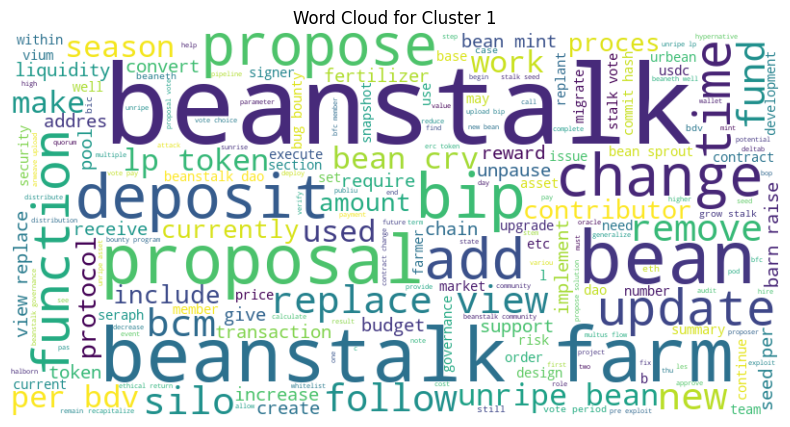

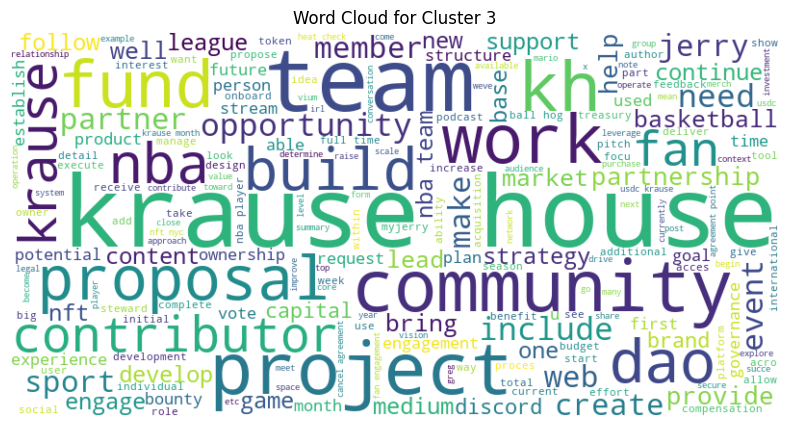

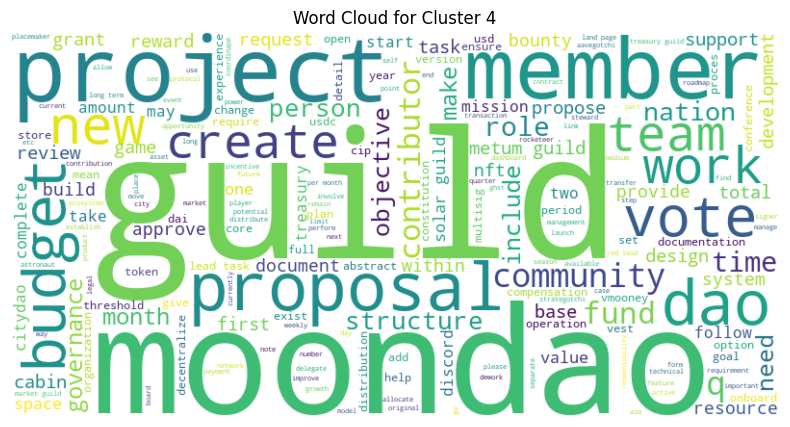

In [172]:
from wordcloud import WordCloud

for cluster_num in temp['Cluster'].unique():
    cluster_text = ' '.join(temp[temp['Cluster'] == cluster_num]['Text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cluster_text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Cluster {cluster_num}')
    plt.show()


In [ ]:
df["choice_win"] = df["choice_win"].apply(argmax)

In [27]:
# space 별로 choice_win value_counts 확인

groups = df.groupby("space_id")
for name, group in groups:
    print(name)
    print(group["choice_win"].value_counts())

01meta.eth
0    1
Name: choice_win, dtype: int64
0xgov.eth
0    19
1     3
2     2
Name: choice_win, dtype: int64
1inch.eth
0    55
1     5
2     1
Name: choice_win, dtype: int64
721nftdao.eth
0    14
3     1
1     1
Name: choice_win, dtype: int64
aave.eth
0     578
1      48
2      18
3       5
6       1
4       1
11      1
21      1
Name: choice_win, dtype: int64
aavegotchi.eth
0    331
1     69
2     12
3      9
7      1
8      1
4      1
Name: choice_win, dtype: int64
abracadabrabymerlinthemagician.eth
0    53
2     2
1     2
Name: choice_win, dtype: int64
acrossprotocol.eth
0    46
1     2
Name: choice_win, dtype: int64
agavedao.eth
0    25
Name: choice_win, dtype: int64
aladdindao.eth
0     49
3      7
2      3
4      3
27     2
21     2
5      2
30     2
29     2
8      2
67     2
31     1
50     1
16     1
41     1
58     1
75     1
7      1
19     1
Name: choice_win, dtype: int64
alchemixstakers.eth
0    79
2    12
1     7
3     4
Name: choice_win, dtype: int64
alpacafinance.e

In [25]:
df[df["choice_len"] > 3][["choices"]].value_counts()

choices                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
['FOR - SharkDAO vote FOR', 'AGAINST - SharkDAO vote AGAINST', 'ABSTAIN - SharkDAO vote ABSTAIN', "DON'T VOTE - SharkDAO skips vote", 'ABSTAIN from SharkDAO vote']                                                                                                                                                                                                                                                                                

In [14]:
df["choice_sentiment"].astype(str).value_counts()

[1, -1]               8943
[1, -1, 1]            5844
[]                    1282
[1, -1, -1]            840
[-1, -1]               674
                      ... 
[1, -1, -1, -1, 1]       2
[-1, 1, 1, -1, -1]       2
[-1, 1, -1, 1, -1]       1
[-1, -1, -1, 1, 1]       1
[-1, 1, -1, 1, 1]        1
Name: choice_sentiment, Length: 62, dtype: int64

In [15]:
df[["choices", "choice_sentiment", "choice_win"]].sort_values(by="choice_sentiment").to_excel("proposals_preprocess_0812_cleanedxxxxx.xlsx", index=False)